In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path # File I/O
import re # Useful for cleaning data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer # I'll try both
from sklearn.svm import SVC, LinearSVC # I think that using a SVM should be best for this problem
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from textblob import TextBlob # To correct spelling errors throughout the dataframe.

# File Input

In [2]:
# Set up filepath to read in sentiment data
basepath = os.path.dirname('__file__')
filepath = os.path.abspath(os.path.join(basepath, 
                                       'Datasets',
                                       'ISEAR_0', 
                                       'isear_databank',
                                       'ISEAR_emotion.xlsx'))
print(filepath)

C:\Users\Tonya\Documents\Mitch's Crap\_Sentiment\Datasets\ISEAR_0\isear_databank\ISEAR_emotion.xlsx


In [3]:
df = pd.read_excel(filepath)

In [4]:
df.head()

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,...,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE
0,11001,1,1,1,1,33,1,2,6,1,...,3,3,2,0,joy,4,3,110011,"During the period of falling in love, each tim...",1
1,11001,1,1,1,1,33,1,2,6,1,...,2,2,0,0,fear,3,2,110012,When I was involved in a traffic accident.,1
2,11001,1,1,1,1,33,1,2,6,1,...,2,1,0,0,anger,1,3,110013,When I was driving home after several days of...,1
3,11001,1,1,1,1,33,1,2,6,1,...,1,1,0,2,sadness,4,4,110014,When I lost the person who meant the most to me.,1
4,11001,1,1,1,1,33,1,2,6,1,...,0,2,0,0,disgust,4,4,110015,The time I knocked a deer down - the sight of ...,1


Based on this, it looks like I'm after 'Field1' (emotion) and SIT (associated text)

Well, some users are problemmatic, so I need to include userID as well.

In [5]:
df = df[['ID','Field1', 'SIT']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 3 columns):
ID        7666 non-null int64
Field1    7666 non-null object
SIT       7666 non-null object
dtypes: int64(1), object(2)
memory usage: 179.8+ KB


In [6]:
line = df['SIT'][2]
line

'When I was driving home after  several days of hard work, there á\nwas a motorist ahead of me who was driving at 50 km/hour and á\nrefused, despite his low speeed to let me overtake.'

# Data Cleaning

In [7]:
# I need to figure out how to strip weird characters out of the text. This has effectively caught
# those pesky accented a's. Somehow they got bundled with newline characters. I'm curious why.
s = r'.\n'
re.sub(s, '', line)

'When I was driving home after  several days of hard work, there was a motorist ahead of me who was driving at 50 km/hour and refused, despite his low speeed to let me overtake.'

In [8]:
# This should do the trick.
def remove_accented_chars(line):
    pattern = r'.\n'
    return re.sub(pattern, '', line)

def remove_brackets(line):
    pattern1 = r'^\[ '
    pattern2 = r']$'
    s = re.sub(pattern1, '', line)
    return re.sub(pattern2, '', s)
    


In [9]:
df['SIT'] = df['SIT'].apply(remove_accented_chars)
df['SIT'] = df['SIT'].apply(remove_brackets)
df['SIT'][14]

'On days when I feel close to my partner and other friends.  When I feel at peace with myself and also experience a close contact with people whom I regard greatly.'

## N/A and duplicate answer cleaning

Looking at the data, special cases need to be handled / replaced. Some lines say things like... [Same as in anger] - which implies the response is the same as given for anger. Occasionally I've come across 'Nothing', 'Not applicable' or 'None' - these rows need to be deleted b/c they're of no use.

N/A answers: [ Do not know.] [ No response.] NO RESPONSE. Doesn't apply. Nothing. None. Not applicable. [ Normally I do not feel disgusted.] [ Can not think of anything just now.] [ Can not think of any situation.] [ Can not remember.] Can't think of any. [ Cannot recall any incident when I felt shame.] [ Do not remember any situation of that kind.] [ Can not think of anything.] [ I do not remember when I last felf ashamed. I do not usually feel ashamed of what I do.] Not applicable to myself. Can't remember any episode of disgust. Blank. Not included on questionnaire. Cannot recall the emotion with any force. Haven't been frightened for ages. Haven't felt shame for ages. Cannot remember such a situation. DO NOT REMEMBER. [ No description.] [ I have not felt this emotion.] [ Never felt the emotion.] [ I have not felt this emotion in my life.] NO RESPONSE (w/o the period) [ I have never felt this emotion.] [ I have felt shame but am unable to remember any particular incident.] [ I have not felt this emotion yet.] [ Never experienced.] [ Never] [ There are many instances which are all equally irratating.] [ Honestly, I have never felt disgust at any situation in my life.] [ Sorry, I was never ashamed about anything in my life.] [ I can positively say that I have never done anything that made me feel guilty.] [ I am quite shameless, not applicable.] [ Not applicable.] [ Do not remember any incident.] 

Duplicate answers: [Same as in anger.], [Same as above ... ], see answer for "shame"., The same as in "shame"., [ The same as in shame.'], [ The same as in anger.], The same event described under "shame"., As in sadness (A), relating to this slaghter of fur-seals., [ The same as in guilt.], The same as in SHAME.,

In [10]:
na_answers = '''Do not know.
No response.
NO RESPONSE.
Doesn't apply.
Nothing.
None.
Not applicable.
Normally I do not feel disgusted.
Can not think of anything just now.
Can not think of any situation.
Can not remember.
Can't think of anything.
I do not remember when I last felf ashamed. I do not usually feel ashamed of what I do.
Not applicable to myself.
Can't remember any episode of disgust.
Blank.
Not included on questionnaire.
Cannot recall the emotion with any force.
Haven't been frightened for ages.
Haven't felt shame for ages.
Cannot remember such a situation.
DO NOT REMEMBER.
No description.
I have not felt this emotion.
Never felt the emotion.
I have not felt this emotion in my life.
NO RESPONSE
I have never felt this emotion.
I have felt shame but am unable to remember any particular incident.
I have not felt this emotion yet.
Never experienced.
Never
There are many instances which are all equally irratating.
Honestly, I have never felt disgust at any situation in my life.
Sorry, I was never ashamed of anything in my life.
I can positively say that I have never done anything that made me feel guilty.
I am quite shameless, not applicable.
Do not remember any incident
Same as in anger.
see answer for "shame".
The same as in shame.
The same as in anger.
The same event described under "shame".
As in sadness (A), relating to this slaughter of fur seals.
The same as in guilt.
The same as in SHAME.'''
na_answers = na_answers.split('\n')

In [11]:
# Writing a function to replace all the non-ansers with np.nan so I can remove them effectively from the dataset.

def replace_non_answers(line):
    if line in na_answers:
        return np.nan
    return line

In [12]:
df['SIT'] = df['SIT'].apply(replace_non_answers)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 3 columns):
ID        7666 non-null int64
Field1    7666 non-null object
SIT       7530 non-null object
dtypes: int64(1), object(2)
memory usage: 179.8+ KB


## NOTE: 
User 261035 sucks dick. His answers aren't even worth catching. It's easier just to exclude him explicitly. Hey, look, he found a friend. 261058.

In [13]:
problem_users = [261035, 261058]

def remove_problem_users(row):
    if row['ID'] in problem_users:
        row['SIT'] = np.nan
        return row
    return row

In [14]:
# let's clip the dataset. It should be ready for processing at this point.
df = df.apply(remove_problem_users, axis=1).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7516 entries, 0 to 7665
Data columns (total 3 columns):
ID        7516 non-null int64
Field1    7516 non-null object
SIT       7516 non-null object
dtypes: int64(1), object(2)
memory usage: 234.9+ KB


In [15]:
# The ID column isn't a useful feature - it was just helpful for cleaning. let's get rid of it.
df = df[['Field1', 'SIT']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7516 entries, 0 to 7665
Data columns (total 2 columns):
Field1    7516 non-null object
SIT       7516 non-null object
dtypes: object(2)
memory usage: 176.2+ KB


After building / a model, it's become clear that there are still issues with the data in that a graph search yields a model with 56.7% accuracy. One of the things I neglected to account for was the ample spelling errors in the dataset. I found a stackoverflow post that might help me out here. https://stackoverflow.com/questions/35070452/how-to-correct-spelling-in-a-pandas-dataframe

In [16]:
df['SIT'] = df['SIT'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

# Text analysis

I want to get avg word / sentence counts on the dataset

In [18]:
df['words'] = df['SIT'].apply(lambda line: len(line.split()))
df['sentences'] = df['SIT'].apply(lambda line: len(line.split('.')))

print('Average word count    : ', np.average(df['words']))
print('Average sentence count: ', np.average(df['sentences']))

Average word count    :  22.2236562001
Average sentence count:  2.57876530069


# Pipeline Building

Since there should be a rather large vocabulary, I think implementing a hashing vectorizer might be the correct choice. However, since there are drawbacks (no idf capabilities, no inverse transform capabilities...), I might as well give the tfidf vectorizer a shot first.

In [18]:
X, y = df['SIT'], df['Field1']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [18]:
pipeline = make_pipeline(TfidfVectorizer(), SVC())
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 
             'svc__C': [.01, .1, 1, 10, 100],
             'svc__gamma': [.01, .1, 1, 10]}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, n_jobs=-1, verbose = 2)
grid.fit(X_train, y_train)
print(grid.best_params_)
grid.score(X_test, y_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 38.5min finished


{'tfidfvectorizer__ngram_range': (1, 2), 'svc__C': 10, 'svc__gamma': 1}


0.5779670037253859

In [19]:
# Curious to see if maybe we're over-fitting.
grid.score(X_train, y_train)

0.99911300337058717

It really looks like we might be. 

So after using TextBlob to correct spelling & playing with the random state param, it doesn't seem like for the time being that I'll get much more accurate than 55 - 60 %. I'm not sure if it's just the quality of the dataset that I'm using or the particular models I'm using -- everywhere I read seems to indicate that for a dataset of this size, SVM's are the way to go. I suppose SGD is an option, I've also seen Naive Bayes and Maximum Entropy classifiers used. NB would certainly be a simpler model.

Just noting, gridsearchcv found best params to be ngram_range = (1, 2), svc C = 10, svc gamma = 1. However, 57.7% test accuracy and 99.9% train accuracy may indicate overfitting.

# Classifier Choice

Here I'm going to compare the performance of a host of classifiers.

## SVC

Above, I used the gridsearch cv to pick a SVC model w/ c = 10 and gamma = 1. Let's compare its performance with varying amounts of training data.

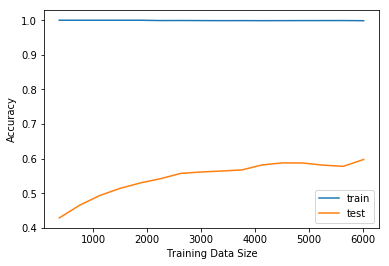

In [20]:
pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), SVC(C=10, gamma=1))
training_percentages = np.arange(.05, .85, .05)
training_data_size = [len(df) * perc for perc in training_percentages]
train_scores = []
test_scores = []
for i in training_percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=i,
                                                        stratify=y, 
                                                        random_state=0)
    pipeline.fit(X_train, y_train)
    train_scores.append(pipeline.score(X_train, y_train))
    test_scores.append(pipeline.score(X_test, y_test))

plt.plot(training_data_size, train_scores, label='train')
plt.plot(training_data_size, test_scores, label='test')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Linear SVC

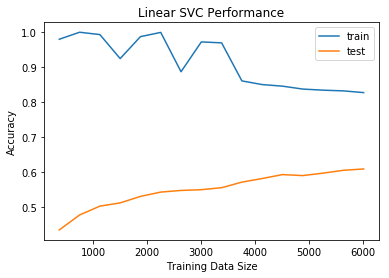

In [36]:
# Use gridsearchCV to fine tune parameters.
pipeline = make_pipeline(TfidfVectorizer(stop_words='english'), LinearSVC())
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidfvectorizer__sublinear_tf': [True, False],
              'linearsvc__C': [.001, .01, .1, 1, 10]}
grid = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, cv=10)
train_scores = []
test_scores = []
param_tracker = {}
for i in training_percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       train_size=i,
                                                       stratify=y,
                                                       random_state=0)
    grid.fit(X_train, y_train)
    param_tracker[i] = grid.best_params_
    train_scores.append(grid.score(X_train, y_train))
    test_scores.append(grid.score(X_test, y_test))
    
plt.plot(training_data_size, train_scores, label='train')
plt.plot(training_data_size, test_scores, label='test')
plt.title('Linear SVC Performance')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
print(list(zip(test_scores, [param_tracker[i] for i in training_percentages])))

[(0.43439294216496288, {'linearsvc__C': 0.01, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__ngram_range': (1, 1)}), (0.47701404286770138, {'linearsvc__C': 0.1, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__ngram_range': (1, 3)}), (0.50226952574737826, {'linearsvc__C': 0.1, 'tfidfvectorizer__sublinear_tf': False, 'tfidfvectorizer__ngram_range': (1, 2)}), (0.51155829037086309, {'linearsvc__C': 0.1, 'tfidfvectorizer__sublinear_tf': False, 'tfidfvectorizer__ngram_range': (1, 1)}), (0.53006918573709416, {'linearsvc__C': 0.1, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__ngram_range': (1, 2)}), (0.54237932345115925, {'linearsvc__C': 1, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__ngram_range': (1, 3)}), (0.54707327056897259, {'linearsvc__C': 0.1, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__ngram_range': (1, 1)}), (0.54922394678492237, {'linearsvc__C': 0.1, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__ngram_range': (1, 2)})

From this, it looks like the Linear SVC shows slight improvement over SVC w/ parameters C = 1 and ngram_range = (1, 3)

## Naive Bayes

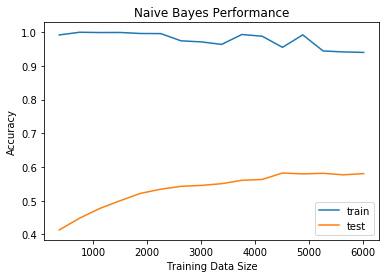

In [28]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
             'multinomialnb__alpha': [.001, .01, .1, 1]}
grid = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, cv=10)
train_scores = []
test_scores = []
param_tracker = {}
for i in training_percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       train_size=i,
                                                       stratify=y,
                                                       random_state=0)
    grid.fit(X_train, y_train)
    param_tracker[i] = grid.best_params_
    train_scores.append(grid.score(X_train, y_train))
    test_scores.append(grid.score(X_test, y_test))
    
plt.plot(training_data_size, train_scores, label='train')
plt.plot(training_data_size, test_scores, label='test')
plt.title('Naive Bayes Performance')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
score_param = list(zip(test_scores, [param_tracker[i] for i in training_percentages]))
print(score_param)

[(0.41338748074499371, {'tfidfvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 1}), (0.44818920916481891, {'tfidfvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}), (0.47722648301768666, {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}), (0.50008315316813567, {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}), (0.5217314174206138, {'tfidfvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1}), (0.53420752565564422, {'tfidfvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1}), (0.54277527629963163, {'tfidfvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1}), (0.54545454545454541, {'tfidfvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1}), (0.55055636187711654, {'tfidfvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1}), (0.56067056945183613, {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}), (0.56310966597694356, {'multinomialnb__alpha': 1, 'tfidfvectorizer__ngra

NB seems to perform best with alpha = 1 and ngram_range = (1, 2). However, this model doesn't seem to perform as well as linear SVC or much better than SVC. I suppose it has the perk of being easier to train than the SVC.

So for now I'm going to go ahead and use a linear svc model.

# Model Performance

In [50]:
pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 3)), LinearSVC(C=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size = 0.8, random_state=0)
pipeline.fit(X_train, y_train)
print('Classifier score:', pipeline.score(X_test, y_test))
print(classification_report(y_test, pipeline.predict(X_test), y.unique()))

Classifier score: 0.616356382979
             precision    recall  f1-score   support

        joy       0.73      0.81      0.77       218
       fear       0.68      0.80      0.73       216
      anger       0.48      0.52      0.50       217
    sadness       0.64      0.60      0.62       216
    disgust       0.62      0.62      0.62       214
      shame       0.54      0.44      0.49       211
      guilt       0.58      0.52      0.55       212

avg / total       0.61      0.62      0.61      1504

